the obligatory: Activation: source tens/bin/activate

In [ ]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap

Loading Data and EDA

In [2]:
data = pd.read_csv("/Users/welpp/Desktop/Practical Data Science/Data/Data Main/goes_13to18.csv",
                   parse_dates=['time'],
                   index_col='time')

data = data[['xrsa_flux', 'xrsb_flux', 'status']]

EDA

In [ ]:
plt.style.use('fivethirtyeight')
data.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

In [ ]:
data['xrsa_flux']['2018':'2022'].plot(figsize=(16,4),legend=True)
data['xrsa_flux']['2022':'2023'].plot(figsize=(16,4),legend=True)
data['xrsa_flux']['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Xrsa (Before 2022)','Xrsa (2022)', 'Xrsa (2023)'])
plt.title('Xrsa Flux Values')
plt.show()

In [ ]:
np.log1p(data['xrsa_flux']['2018':'2022']).plot(figsize=(16,4),legend=True)
np.log1p(data['xrsa_flux']['2022':'2023']).plot(figsize=(16,4),legend=True)
np.log1p(data['xrsa_flux']['2023':]).plot(figsize=(16,4),legend=True)
plt.legend(['Xrsa (Before 2022)','Xrsa (2022)', 'Xrsa (2023)'])
plt.title('Xrsa Log Flux Values')
plt.show()

In [ ]:
data['xrsb_flux'][:'2022'].plot(figsize=(16,4),legend=True)
data['xrsb_flux']['2022':'2023'].plot(figsize=(16,4),legend=True)
data['xrsb_flux']['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Xrsb (Before 2022)','Xrsb (2022)', 'Xrsb (2023)'])
plt.title('Xrsb Flux Values')
plt.show()

In [ ]:
np.log1p(data['xrsb_flux'][:'2022']).plot(figsize=(16,4),legend=True)
np.log1p(data['xrsb_flux']['2022':'2023']).plot(figsize=(16,4),legend=True)
np.log1p(data['xrsb_flux']['2023':]).plot(figsize=(16,4),legend=True)
plt.legend(['Xrsa (Before 2022)','Xrsa (2022)', 'Xrsa (2023)'])
plt.title('Xrsb Log Flux Values')
plt.show()

In [ ]:
plt.hist2d(data['xrsa_flux'], data['xrsb_flux'], bins=(20, 20), vmax=200)
plt.colorbar()
plt.xlabel('xrsa_flux')
plt.ylabel('xrsb_flux')

In [ ]:
corr_matrix = data.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Data Processing

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
# values directly

df = data.copy()
flux = df[['xrsa_flux','xrsb_flux']]

scaler = MinMaxScaler(feature_range=(0, 1))
flux = scaler.fit_transform(flux)

df['xrsa_flux'] = flux[:,0]
df['xrsb_flux'] = flux[:,1]

## data splits
train = df['2016':'2022']
val = df['2022':'2023']
test = df['2023':]

In [ ]:
# logit flux values

df_log = data.copy()
df_log[['xrsa_flux', 'xrsb_flux']] = np.log1p(data[['xrsa_flux', 'xrsb_flux']])
df_log = df_log['2018':]

## minmax scaling flux values only
flux = df_log[['xrsa_flux','xrsb_flux']]
scaler = MinMaxScaler(feature_range=(0, 1))
flux = scaler.fit_transform(flux)

df_log['xrsa_flux'] = flux[:,0]
df_log['xrsb_flux'] = flux[:,1]

## data splits
train = df_log['2019':'2022']
val = df_log['2022':'2023']
test = df_log['2023':]

In [5]:
## step for np transform
train = train.to_numpy()
val = val.to_numpy()
test = test.to_numpy()

In [6]:
X_train_xrsa = []
X_train_xrsb = []
y_train = []
X_val_xrsa = []
X_val_xrsb = []
y_val = []
X_test_xrsa = []
X_test_xrsb = []
y_test = []
timesteps = 100
halfpoint = int(timesteps/2)

for i in range(len(train) - timesteps):
    X_train_xrsa.append(train[i:i + timesteps, 0])
    X_train_xrsb.append(train[i:i + timesteps, 1])
    y_train.append(train[i + halfpoint,2])

for i in range(len(val) - timesteps):
    X_val_xrsa.append(val[i:i + timesteps, 0])
    X_val_xrsb.append(val[i:i + timesteps, 1])
    y_val.append(val[i + halfpoint,2])

for i in range(len(test) - timesteps):
    X_test_xrsa.append(test[i:i + timesteps, 0])
    X_test_xrsb.append(test[i:i + timesteps, 1])
    y_test.append(test[i + halfpoint,2])

X_train_a, X_train_b = np.array(X_train_xrsa), np.array(X_train_xrsb)
y_train = np.array(y_train)
X_train = np.stack((X_train_a, X_train_b), axis = 2)

X_val_a, X_val_b = np.array(X_val_xrsa), np.array(X_val_xrsb)
y_val = np.array(y_val)
X_val = np.stack((X_val_a, X_val_b), axis = 2)

X_test_a, X_test_b = np.array(X_test_xrsa), np.array(X_test_xrsb)
y_test = np.array(y_test)
X_test = np.stack((X_test_a, X_test_b), axis = 2)

Model Building

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, TimeDistributed, Bidirectional, Flatten, MaxPooling1D
from tensorflow.keras.layers import Dropout, BatchNormalization

from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, classification_report

In [8]:
1-sum(y_train)/len(y_train)

0.9974753170444873

In [9]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
class_weight_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

LSTM

In [ ]:
## LSTM
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64)

In [ ]:
## LSTM Bidirectional
model2 = Sequential()
model2.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dense(100, activation = 'relu'))
model2.add(Dropout(0.3))
model2.add(Dense(100, activation = 'relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history2 = model2.fit(X_train, y_train, epochs=5, batch_size=64)

Conv1D

In [ ]:
## 1D convolution
model3 = Sequential()
model3.add(Conv1D(64, 2, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
model3.add(Dense(100, activation="relu"))
model3.add(MaxPooling1D())
model3.add(Conv1D(64, 2, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
model3.add(Dense(100, activation="relu"))
model3.add(MaxPooling1D())
model3.add(Flatten())
model3.add(Dense(100, activation="relu"))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(X_train, y_train, epochs=5, batch_size=64, class_weight=class_weight_dict)

In [ ]:
history4 = model3.fit(X_train, y_train, epochs=5, batch_size=64)

Merger

In [10]:
model5 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal",
                          activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=False),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model5.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer, metrics=['accuracy'])

In [12]:
history5 = model5.fit(X_train, y_train, epochs=4, batch_size=64)

Epoch 1/4
57291/57291 [==============================] - 7610s 133ms/step - loss: 0.0013 - accuracy: 0.9975
Epoch 2/4
57291/57291 [==============================] - 7747s 135ms/step - loss: 0.0013 - accuracy: 0.9975
Epoch 3/4
57291/57291 [==============================] - 7547s 132ms/step - loss: 0.0013 - accuracy: 0.9975
Epoch 4/4
57291/57291 [==============================] - 7595s 133ms/step - loss: 0.0013 - accuracy: 0.9975


Evaluation

In [13]:
from scipy import stats
import sklearn.metrics as metrics

In [14]:
y_pred = model5.predict(X_test)

12211/12211 [==============================] - 160s 13ms/step


In [15]:
y_pred.shape

(390733, 1)

In [20]:
y_mean = np.mean(y_pred)
y_median = np.median(y_pred)
y_mode = stats.mode(y_pred)[0][0]
print(y_mean)
print(y_median)
print(y_mode)

y_pred_binary = (y_pred > y_mean).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
classification_rep = classification_report(y_test, y_pred_binary)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

0.0002153475
0.00020146245
0.00019787653582170606
Confusion Matrix:
[[308867  79566]
 [  1569    731]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.80      0.88    388433
         1.0       0.01      0.32      0.02      2300

    accuracy                           0.79    390733
   macro avg       0.50      0.56      0.45    390733
weighted avg       0.99      0.79      0.88    390733



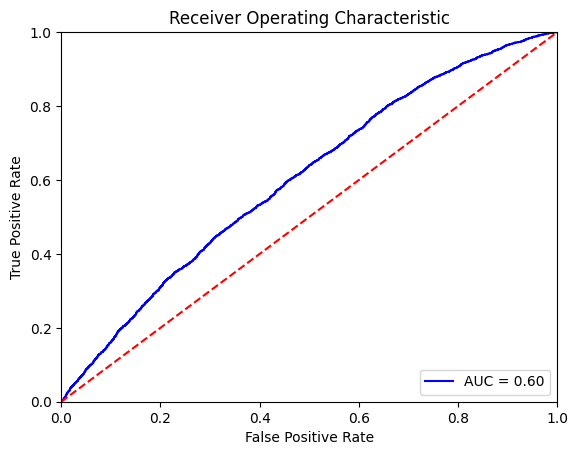

In [21]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
test2 = df['2023':].iloc[50:390783]
test2["pred"] = y_pred_binary

In [ ]:
test2 = test2['2023-10-02 05:30:00':'2023-10-02 06:30:00']

In [ ]:
t_n = test2[(test2['status'] == 0) & (test2['pred'] == 0)]
t_p = test2[(test2['status'] == 1) & (test2['pred'] == 1)]
f_p = test2[(test2['status'] == 0) & (test2['pred'] == 1)]
f_n = test2[(test2['status'] == 1) & (test2['pred'] == 0)]

# Plot the data
plt.figure(figsize=(10, 6))

# Plot status 0 in blue
plt.scatter(t_n.index, t_n['xrsa_flux'], color='blue', label='true neg', s=10, alpha=0.5)

# Plot status 1 in green
plt.scatter(f_n.index, f_n['xrsa_flux'], color='green', label='false neg', s=10, alpha=0.5)

# Plot pred 0 in red
plt.scatter(f_p.index, f_p['xrsa_flux'], color='red', label='false pos', s=10, alpha=0.5)

# Plot pred 1 in orange
plt.scatter(t_p.index, t_p['xrsa_flux'], color='orange', label='true pos', s=10, alpha=0.5)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('xrsa_flux')
plt.title('Time Series Plot with Status and Pred')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
test2['xrsa_flux']['2023':].plot(figsize=(16,4),legend=True)
plt.title('Xrsa Flux Values')
plt.show()

In [ ]:
test2['xrsb_flux']['2023':].plot(figsize=(16,4),legend=True)
plt.title('Xrsa Flux Values')
plt.show()